In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, ConcatDataset, Subset
# from torch.utils.data import sampler


import torchvision.datasets as dset
import torchvision.transforms as T

from PIL import Image

# disable warnings
Image.MAX_IMAGE_PIXELS = None # image processing
# auto-reload functions before each instance running them
%load_ext autoreload
%autoreload 2

In [2]:
# Remote instance set-up cell
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cpu


In [3]:
# directory setup cell
repo = 'tree-finder/'
location = 'local'
save_files = False

# Local paths
local_root = '/Users/etriesch/dev/'
colab_root = '/content/drive/My Drive/git/'
aws_root = '/home/ec2-user/'

# define root
if location == 'local':
  root = local_root
elif location == 'google':
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  root = colab_root
elif location == 'aws':
  root = aws_root

repo_path = root + repo
model_path = repo_path + 'models/'
data_path = repo_path + 'data/'
results_path = repo_path + 'results/'
sys.path.append(repo_path)

In [4]:
# setup cell
from notebooks.viz_fns import show_image_batch, set_plt_settings
from notebooks.data_processing import define_transforms, make_dataloaders, get_tree_class_likelihood, IMAGE_DIM, MEAN, STD
from notebooks.models import ResnetTransferClassifier
from notebooks.scrape_fns import get_filelist

set_plt_settings()

# Make dataset and loaders
This includes augmenting my dataset

In [5]:
# define transformations
transforms = define_transforms(scale_up=1024, crop=1024, scale_out=IMAGE_DIM, mean=MEAN, std=STD, mirror=True, randomcrop=[10,25,50])
# create dataset by concatenating all transformations
treeds = []
for t in transforms:
    df = dset.ImageFolder(root=data_path + 'images_spec', transform=transforms[t])
    treeds.append(df)

treeds = ConcatDataset(treeds)
class_names = treeds.datasets[0].classes

In [6]:
# make whole-dataset loader and sample loader
loader_all = DataLoader(dataset=treeds, batch_size=32, shuffle=False)

random_idxs = np.random.choice(range(len(treeds)), 200).tolist()
loader_samp = DataLoader(dataset=Subset(treeds, random_idxs), batch_size=6, shuffle=True)

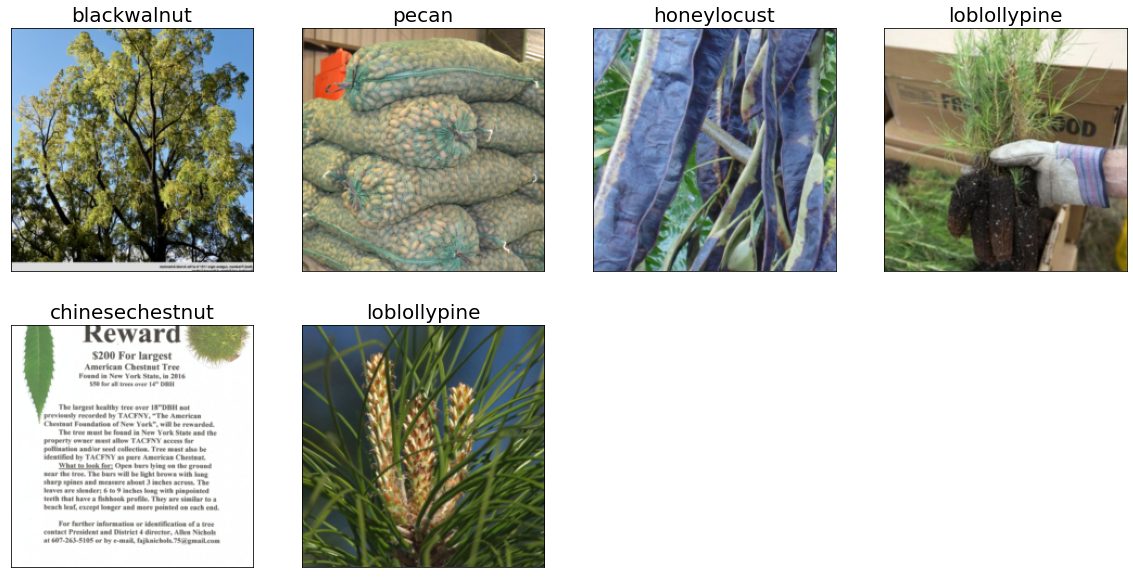

In [7]:
# visualize images
samp_imgs, samp_classes = next(iter(loader_samp))
samp_imgs, samp_classes = samp_imgs.to(device), samp_classes.to(device)

# print(type(imgs), type(labels))
show_image_batch(samp_imgs.cpu(), MEAN, STD, title=[class_names[x] for x in samp_classes])

# Generate indices to subset dataset, based on binary tree classifier

In [8]:
# load binary classifier
model = ResnetTransferClassifier(num_classes=2, retrain_last_cnblock=False)
model.load_state_dict(torch.load(model_path + 'ResnetBinClassifier.pt', map_location=torch.device('cpu')))
model.to(device)
model.eval()
print('success!')

success!


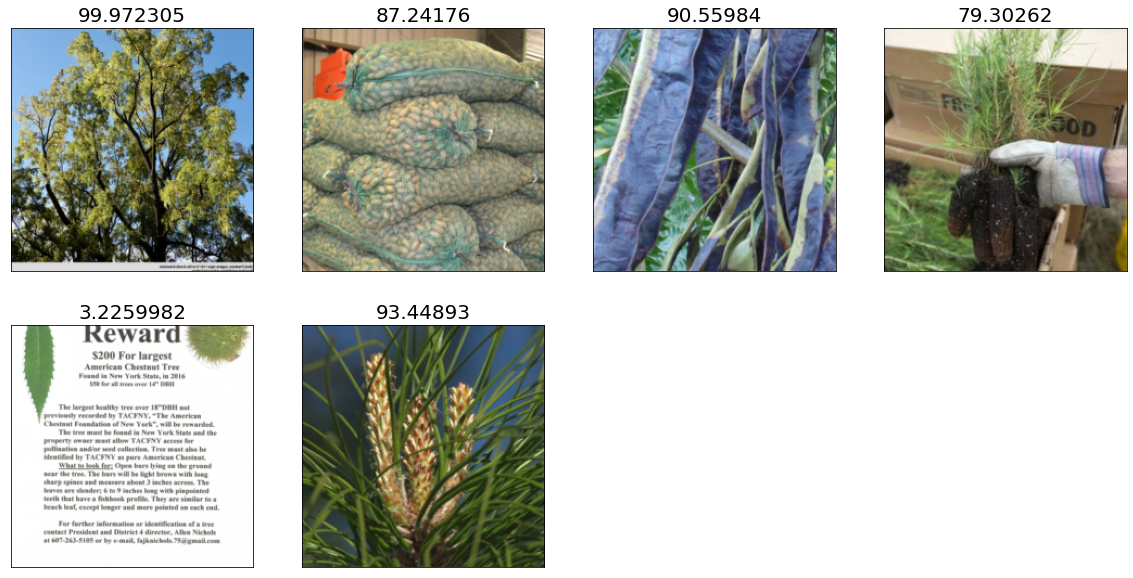

In [9]:
# print scores for sample of images
scores = model(samp_imgs)
percentage = F.softmax(scores, dim=1) * 100
# print trees and score for detecting tree for a random sample of images
tree_likelihood = percentage[:,1].cpu().detach().numpy()
show_image_batch(samp_imgs.cpu(), MEAN, STD, title=tree_likelihood)

In [ ]:
# get indices for subsetting based on model classification
realtree_likelihood = get_tree_class_likelihood(classifier=model, loader=loader_all, device=device)

  4%|███▏                                                                       | 44/1026 [01:14<23:23,  1.43s/it]/opt/conda/envs/pytorch/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████| 1026/1026 [5:32:13<00:00, 19.43s/it]


In [ ]:
# save to file
if save_files:
  filename = 'images_spec_realtree_pcts.csv'
  np.savetxt(data_path + filename, np.array(realtree_likelihood), delimiter=",", fmt='%1.4f')

[autoreload of notebooks.data_processing failed: Traceback (most recent call last):
  File "/home/ec2-user/.local/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/ec2-user/.local/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/opt/conda/envs/pytorch/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/ec2-user/tree-finder/notebooks/data_processing.py", line 38
    transforms[f'crop{pct}_mirr'] = T.Compose([T.Resiz

# Summarize original, augmented, and subset datasets

In [10]:
# load image scores
filename = 'images_spec_realtree_pcts.csv'
realtree_likelihood = np.loadtxt(data_path + filename).astype(float).tolist()

# subset based on threshold
threshold=0.85
flag = np.array(realtree_likelihood) > threshold
realtree_idxs = (np.arange(0, len(flag))[flag]).tolist()
print(f'\nimages meeting threshold ({threshold}): {sum(flag)} ({sum(flag)/len(flag):0.2%})')
# realtree_idxs = None

tree_filelist, image_filelist = get_filelist(data_path + 'images_spec')


images meeting threshold (0.85): 24944 (75.97%)


### Print 6 worst images

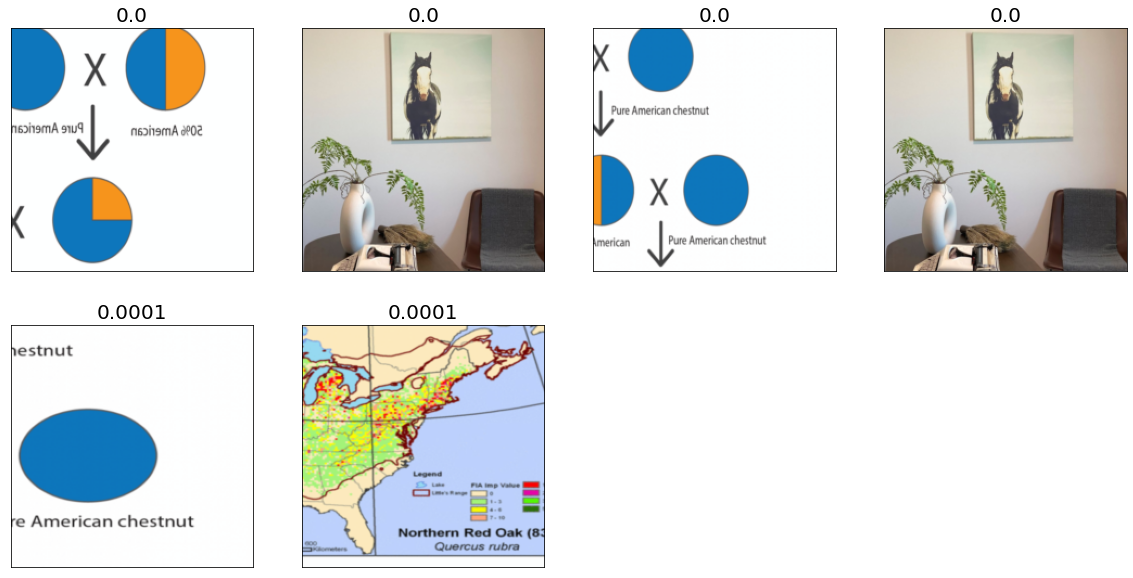

In [11]:
# examine the 6 worst indices (we'll likely be dropping these)
n = 6
bad_idx = np.argsort(np.array(realtree_likelihood))[:n].tolist()

dset_bad = Subset(treeds, bad_idx)
badloader = DataLoader(dset_bad, batch_size=n, shuffle=False)
X, y = next(iter(badloader))
show_image_batch(X, MEAN, STD, title=np.array(realtree_likelihood)[bad_idx])

### Print 4 sample images with species and score

dataloader sizes: {'all': 24944, 'train': 16836, 'validate': 5613, 'test': 2495, 'sampler': 4}
image saved to file: /Users/etriesch/dev/tree-finder/results/fig_samp_imgs.png


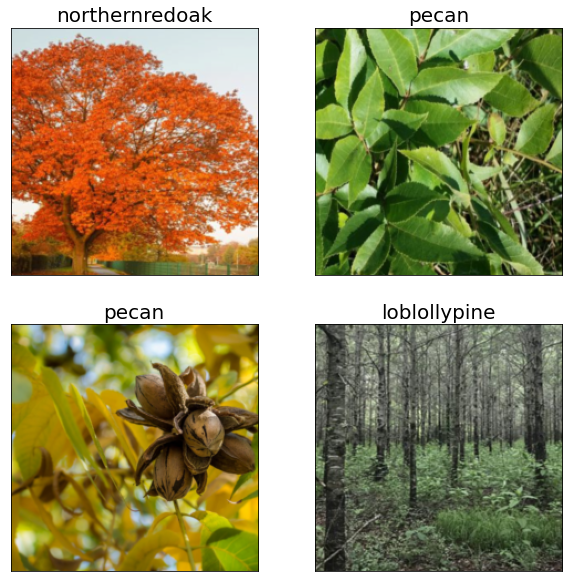

In [12]:
dataloaders, ds_sizes = make_dataloaders(
    dataset=treeds, subset=realtree_idxs, test_split=0.10, val_split=0.25, 
    sampleN=4, batch_size=32, seed=20)

X_samp, y_samp = next(iter(dataloaders['sampler']))
show_image_batch(X_samp, MEAN, STD, title=[class_names[x] for x in y_samp], 
    figdim=10, ncol=2, savetofile=results_path + 'fig_samp_imgs.png')

## Print normalized scaled imaes

dataloader sizes: {'all': 24944, 'train': 16836, 'validate': 5613, 'test': 2495, 'sampler': 4}


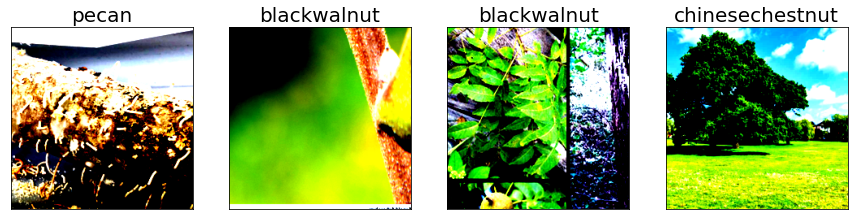

In [14]:
dataloaders, ds_sizes = make_dataloaders(
    dataset=treeds, subset=realtree_idxs, test_split=0.10, val_split=0.25, 
    sampleN=4, batch_size=32, seed=20)

X_samp, y_samp = next(iter(dataloaders['sampler']))
show_image_batch(X_samp, title=[class_names[x] for x in y_samp], 
    figdim=15, ncol=4, savetofile=None)

In [20]:
tree_filelist, image_filelist = get_filelist(data_path + 'images_spec')

dataloader sizes: {'all': 24944, 'train': 16836, 'validate': 5613, 'test': 2495, 'sampler': 4}
image saved to file: /Users/etriesch/dev/tree-finder/results/fig_samp_imgs.png


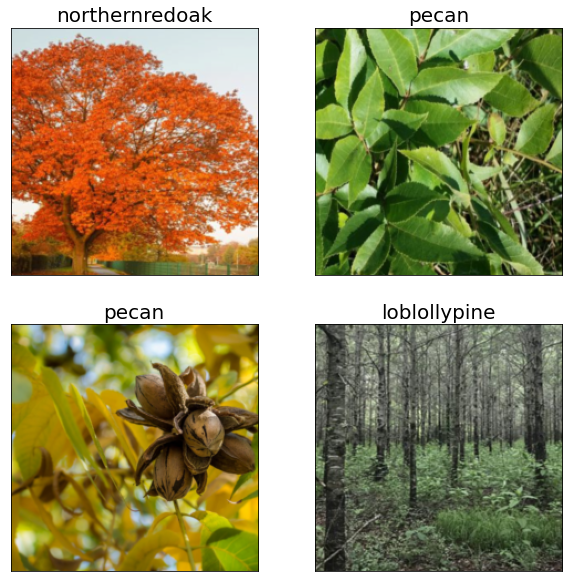

In [ ]:
dataloaders, ds_sizes = make_dataloaders(
    dataset=treeds, subset=realtree_idxs, test_split=0.10, val_split=0.25, 
    sampleN=4, batch_size=32, seed=20)

X_samp, y_samp = next(iter(dataloaders['sampler']))
show_image_batch(X_samp, MEAN, STD, title=[class_names[x] for x in y_samp], 
    figdim=10, ncol=2, savetofile=results_path + 'fig_samp_imgs.png')

In [21]:
# original dataset
tree_summary = dict.fromkeys(tree_filelist.keys(), [0,0,0,0])

for k, i in tree_filelist.items():
    a = np.array(i)
    count_all = len(a)
    count_bing = len(a[np.char.startswith(a, 'bing-')])
    count_arbor = len(a[np.char.startswith(a, 'arborday-')])
    count_harvard = len(a[np.char.startswith(a, 'harvard-')])
    tree_summary[k] = np.array([count_all, count_bing, count_arbor, count_harvard])
    try:
        tree_summary['all'] += tree_summary[k]
    except:
        tree_summary['all'] = tree_summary[k].copy()

In [22]:
# augmented dataset
tree_summary_aug = tree_summary.copy()
for k in tree_summary.keys():
    tree_summary_aug[k] = [d*8 for d in tree_summary[k]]

In [23]:
# subset dataset
image_filelist_sub = np.array(image_filelist*8)[realtree_idxs]
tree_summary_sub = dict.fromkeys(tree_filelist.keys(), [0,0,0,0])
for k in tree_filelist.keys():
    a = image_filelist_sub[np.char.startswith(image_filelist_sub, k)]
    count_all = len(a)
    count_bing = len(a[np.char.startswith(a, f'{k}-bing-')])
    count_arbor = len(a[np.char.startswith(a, f'{k}-arborday-')])
    count_harvard = len(a[np.char.startswith(a, f'{k}-harvard-')])
    tree_summary_sub[k] = np.array([count_all, count_bing, count_arbor, count_harvard])
    try:
        tree_summary_sub['all'] += tree_summary_sub[k]
    except:
        tree_summary_sub['all'] = tree_summary_sub[k].copy()

In [24]:
# summary
print('original dataset (all, bing, arborday, harvard):')
print(tree_summary)
print('augmented dataset:')
print(tree_summary_aug)
print('filtered dataset:')
print(tree_summary_sub)

original dataset (all, bing, arborday, harvard):
{'honeylocust': array([501, 501,   0,   0]), 'northernredoak': array([579, 531,   7,  41]), 'blackwalnut': array([651, 563,   4,  84]), 'pecan': array([611, 591,   6,  14]), 'loblollypine': array([495, 488,   7,   0]), 'chinesechestnut': array([662, 467,   3, 192]), 'blacklocust': array([605, 562,   0,  43]), 'all': array([4104, 3703,   27,  374])}
augmented dataset:
{'honeylocust': [4008, 4008, 0, 0], 'northernredoak': [4632, 4248, 56, 328], 'blackwalnut': [5208, 4504, 32, 672], 'pecan': [4888, 4728, 48, 112], 'loblollypine': [3960, 3904, 56, 0], 'chinesechestnut': [5296, 3736, 24, 1536], 'blacklocust': [4840, 4496, 0, 344], 'all': [32832, 29624, 216, 2992]}
filtered dataset:
{'honeylocust': array([2925, 2925,    0,    0]), 'northernredoak': array([3535, 3239,   42,  254]), 'blackwalnut': array([3845, 3335,   23,  487]), 'pecan': array([3875, 3766,   30,   79]), 'loblollypine': array([3106, 3060,   46,    0]), 'chinesechestnut': array([

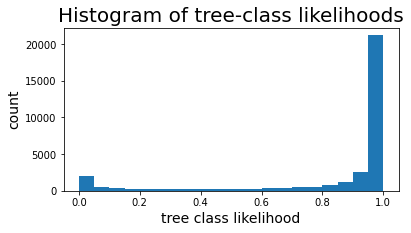

In [37]:
fig, ax = plt.subplots(figsize=(6, 3))
plt.hist(realtree_likelihood, bins=20)
plt.ylabel('count')
plt.xlabel('tree class likelihood')
plt.savefig(results_path + 'fig_histTreeClassFilter.png', bbox_inches='tight')


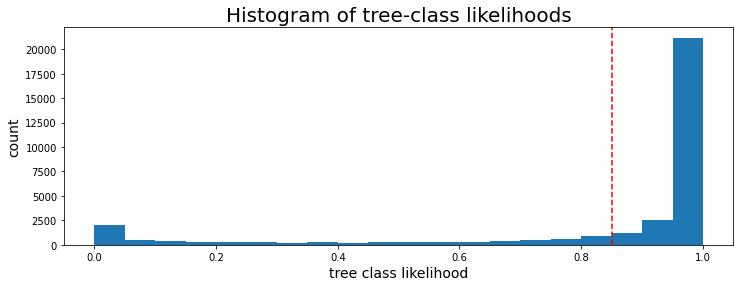

In [22]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.hist(realtree_likelihood, bins=20)
plt.axvline(x=0.85, c='r', linestyle='--')
plt.ylabel('count')
plt.xlabel('tree class likelihood')
plt.title('Histogram of tree-class likelihoods')
plt.show()

In [25]:
# save results to file
if save_files:
  filename = 'dataset_processing_summary.csv'
  dataset_summ = pd.DataFrame({})
  for summ, desc in zip([tree_summary, tree_summary_aug, tree_summary_sub], ['original', 'augmented', 'filtered']):
      d = pd.DataFrame(summ)
      d.loc[:,'step'] = desc
      d.loc[:,'set'] = pd.Series(['all', 'bing', 'arborday', 'harvard'])
      dataset_summ = pd.concat((d, dataset_summ))

  dataset_summ.reset_index()
  dataset_summ.to_csv(results_path + filename, index=False)